# Dag layer cost visualization
In this notebook we will visualize the dags built from the different profiling schemes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
from schedule_simulator_core.DAGs import deserialize_dag
from schedule_simulator_core.utils import Mbps_to_Bpns

In [17]:
def plot_dag_overall_costs(dag, title=None, scaling_factors=None, figsize=(8,6)):
    costs = dict(forward_pass_units=0, backward_pass_units=0, communication_units=0)
    for layer in dag.topological_order:
        for cost in costs.keys():
            if scaling_factors is not None and cost in scaling_factors:
                m = scaling_factors[cost]
            else:
                m = 1
            costs[cost] += getattr(layer, cost) * m
    print("comp_to_comm_ratio: {}".format((costs["forward_pass_units"] + costs["backward_pass_units"]) / 
                                         costs["communication_units"]))
    data = list(zip(*costs.items()))
    f = None
    if figsize is not None:
        f = plt.figure(figsize=figsize)
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} {})".format(pct, absolute, time_unit)
    plt.pie(x=data[1], labels=data[0], autopct=lambda pct: func(pct, data[1]),
            textprops=dict(color="w", size=16))
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()
    return f

In [11]:
def plot_dag_layer_wise_costs(dag, title=None, stacked=False, width=0.7, scaling_factors=None, figsize=(14,8)):
    N = len(dag.topological_order)
    xticks = list()
    costs = dict(forward_pass_units=list(), backward_pass_units=list(), communication_units=list())
    for layer in dag.topological_order:
        xticks.append(layer.extras["name"])
        for cost in costs.keys():
            if scaling_factors is not None and cost in scaling_factors:
                m = scaling_factors[cost]
            else:
                m = 1
            costs[cost].append(getattr(layer, cost) * m)

    f = None
    if figsize is not None:
        f = plt.figure(figsize=figsize)
    ind = np.arange(N)  # the x locations for the groups

    if stacked:
        accumulated_costs = np.zeros(shape=N)
        for cost in costs.keys():
            p = plt.bar(ind, costs[cost], width, bottom=accumulated_costs, label=cost)
            accumulated_costs += costs[cost]
    else:
        n = len(costs)
        for j, cost in enumerate(costs.keys()):
            p = plt.bar(ind - width / 2 + width / n * j, costs[cost], width / n, label=cost)
    plt.ylabel('Time per batch ({})'.format(time_unit))
    plt.xlabel("Layer name")
    if title is not None:
        plt.title(title)
    plt.xticks(ind, xticks, rotation="vertical")
    plt.legend()
    plt.axhline(0, color='black')
    plt.show()
    return f

In [60]:
def plot_dag(dag, title, scaling_factors):
    f = plot_dag_overall_costs(dag, title="Overall costs", scaling_factors=scaling_factors)
    f = plot_dag_layer_wise_costs(dag, title="Layerwise costs", scaling_factors=scaling,
                                 stacked=True)
    if title is not None:
        plt.suptitle(title)

In [61]:
network_rate = 15
network_unit = "Gbps"
Bpns_network_rate = Mbps_to_Bpns(network_rate)*1e3
time_mult = 1e-6
time_unit = "ms"
scaling = dict(communication_units=1/Bpns_network_rate*time_mult, forward_pass_units=time_mult, 
              backward_pass_units=time_mult)

## Model reconstruction profiling dags

comp_to_comm_ratio: 1.7591370573367509


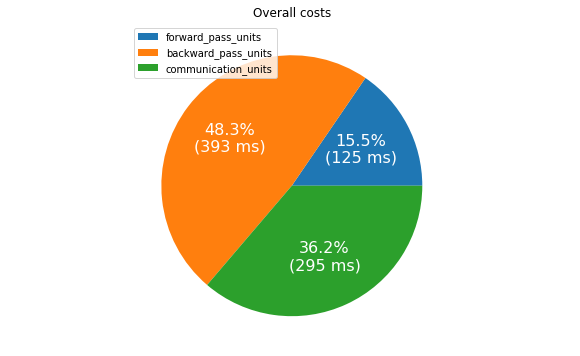

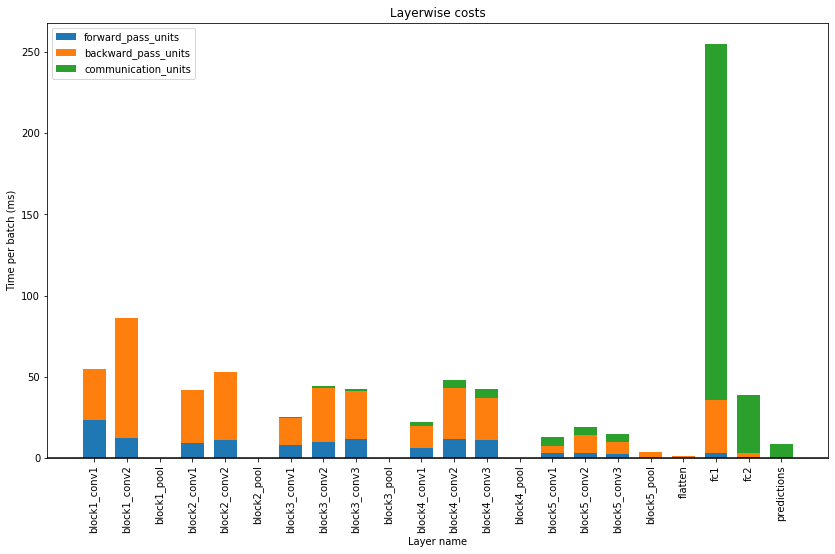

<Figure size 432x288 with 0 Axes>

In [62]:
file_name = "VGG16_CPU_mr.dag"
with open("../model_extraction/dags/{}".format(file_name)) as file:
    dag = deserialize_dag(file.read())
    title = "{} ({} {})".format(file_name, network_rate, network_unit)
    plot_dag(dag, title, scaling_factors=scaling)

comp_to_comm_ratio: 1.2743938521993703


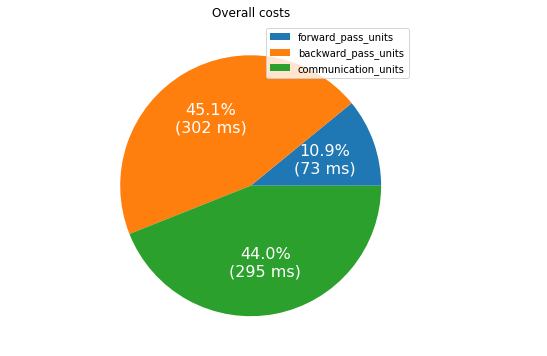

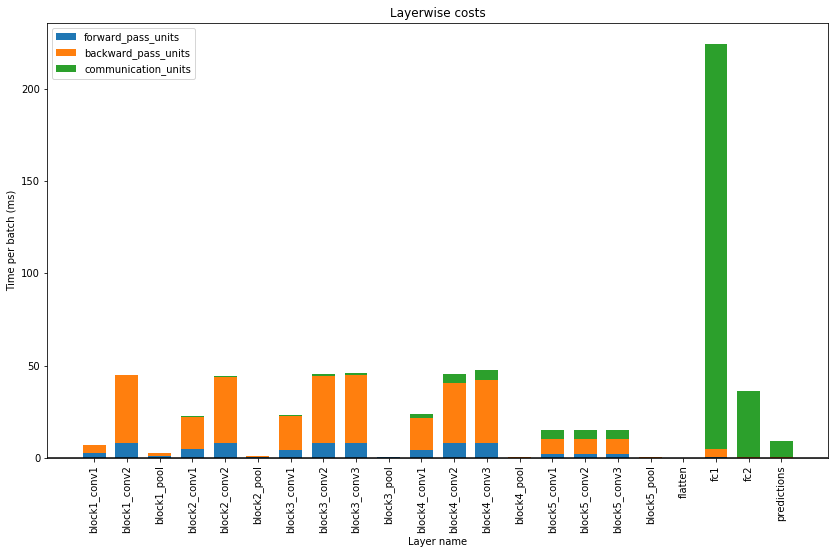

<Figure size 432x288 with 0 Axes>

In [63]:
file_name = "VGG16_CPU_lnm.dag"
with open("../model_extraction/dags/{}".format(file_name)) as file:
    dag = deserialize_dag(file.read())
    title = "{} ({} {})".format(file_name, network_rate, network_unit)
    plot_dag(dag, title, scaling_factors=scaling)